In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Define transforms

In [21]:
transform = transforms.Compose([ transforms.ToTensor(), # Normalizes to range [0,1]
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]), # Also part of normalization
                        transforms.Resize((224, 224))
                       ])

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/MyDrive/emerging-technologies/assignment_02

/content/drive/MyDrive/emerging-technologies/assignment_02


## Prepare train and test sets, loaders

In [24]:
train_data = datasets.ImageFolder('Covid19-dataset/train', transform = transform)
test_data = datasets.ImageFolder('Covid19-dataset/test', transform = transform)

In [25]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Covid', 'Normal', 'Viral Pneumonia']
Training images available: 251
Testing images available:  66


## Display a batch of images


In [26]:
for images,labels in train_loader:
    break
images.shape

torch.Size([32, 3, 224, 224])

In [27]:
labels

tensor([0, 0, 2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0,
        0, 1, 0, 1, 0, 1, 2, 2])

Label: [0 0 2 0 2 0 0 2]
Class: Covid Covid Viral Pneumonia Covid Viral Pneumonia Covid Covid Viral Pneumonia


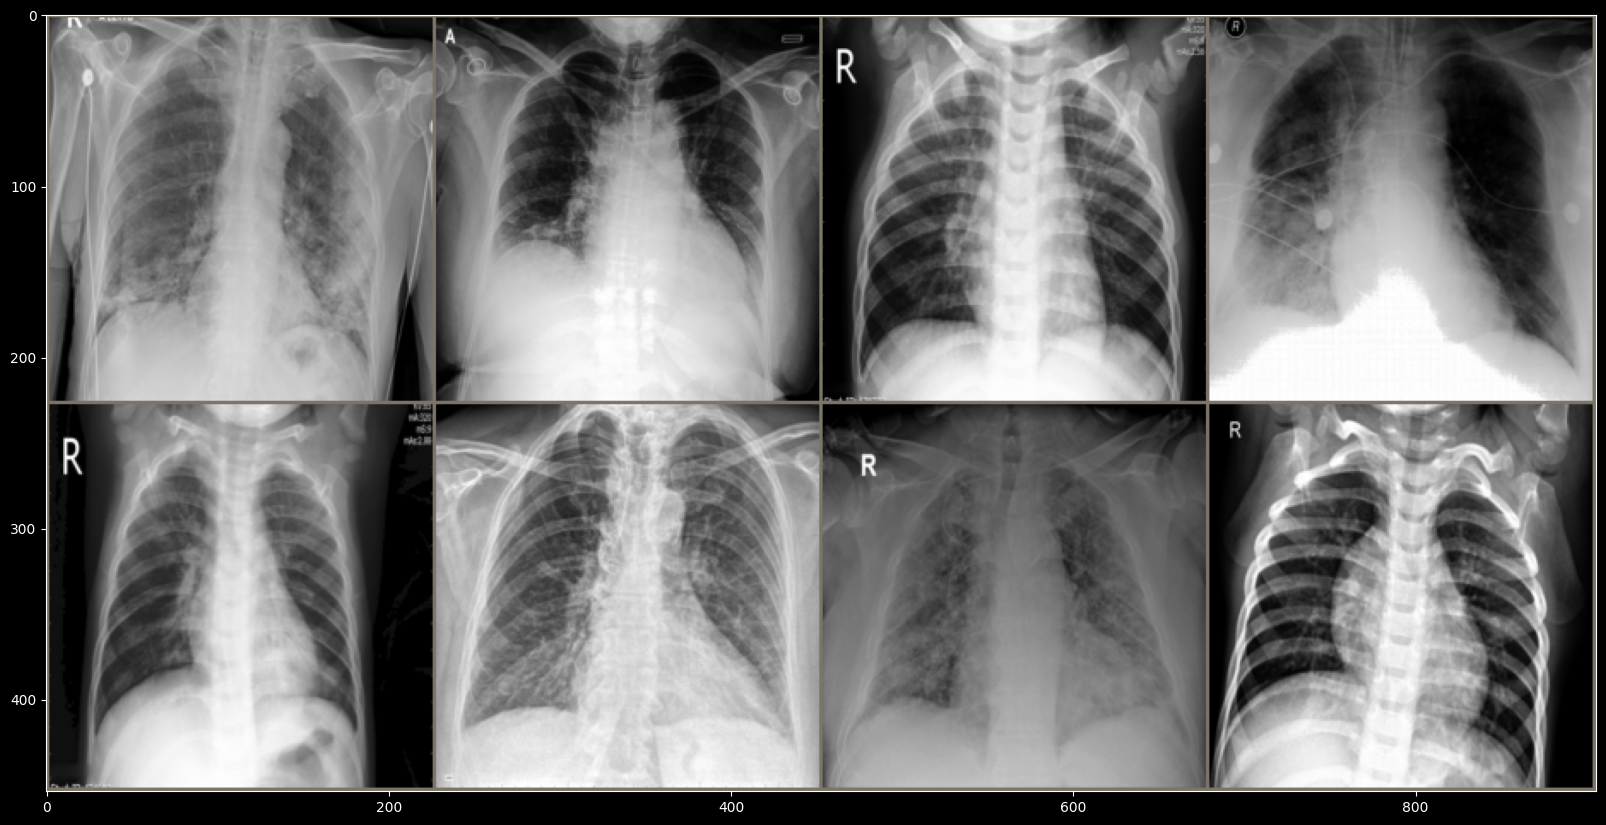

In [28]:
# Print the labels

print('Label:', labels[:8].numpy())
print('Class:', *np.array([class_names[i] for i in labels[:8]]))

im = make_grid(images[:8,:,:,:], nrow=4)  # 16 images in a row
# Inverse normalize the images

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose((im_inv.numpy()*255).astype(np.uint8), (1, 2, 0))); # we see that dataloader has shuffle the images

##  Import ResNet-18

In [29]:
alexnet = models.alexnet('AlexNet_Weights.DEFAULT')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [30]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [31]:
# count the total number of parameters in the model
summary(alexnet.cuda(),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Freeze all the Layers

In [32]:
# Freeze all layers
for p in alexnet.parameters():
    p.requires_grad = False


# Unfreeze and Change the Final Layer

In [33]:
alexnet.classifier[6] = nn.Linear(4096,3)

# Put ResNet on GPU

In [34]:
alexnet.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Training and Testing the model

In [35]:
epochs = 5

# loss function

lossfunc = nn.CrossEntropyLoss()

# optimizer

optimizer = torch.optim.SGD(alexnet.parameters(), momentum = 0.9, lr = 0.01)


  # Initialize losses and Accuracies

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


# loop over epochs

for epoch in range(epochs):
 alexnet.train()

 # loop over training data batches

 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:

  X = X.to(device) # Placing features on device
  y = y.to(device) # placing labels on device

  ypred = alexnet(X)
  loss = lossfunc(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Append batchloss

  batchLoss.append(loss.item())

  ypred = ypred.cpu() # Back to cpu
  y = y.cpu()

  # compute batch accuracy

  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)
# Batch loop concluded

# Average training accuracy (Outside the batchloop)

 trainAcc.append(np.mean(batchAcc))

# Losses through epochs

 losses[epoch] = np.mean(batchLoss)

# TESTING the model

 alexnet.eval()
 X,y = next(iter(test_loader))
 X = X.to(device)
 y = y.to(device)

 with torch.no_grad(): #This step  Deactivating autogradient
  ypred = alexnet(X)
  ypred = ypred.cpu()
  y = y.cpu()

 # Appending test accuracy

  testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))


  print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.40
 epochs : 1  loss :  0.29
 epochs : 2  loss :  0.09
 epochs : 3  loss :  0.18
 epochs : 4  loss :  0.20


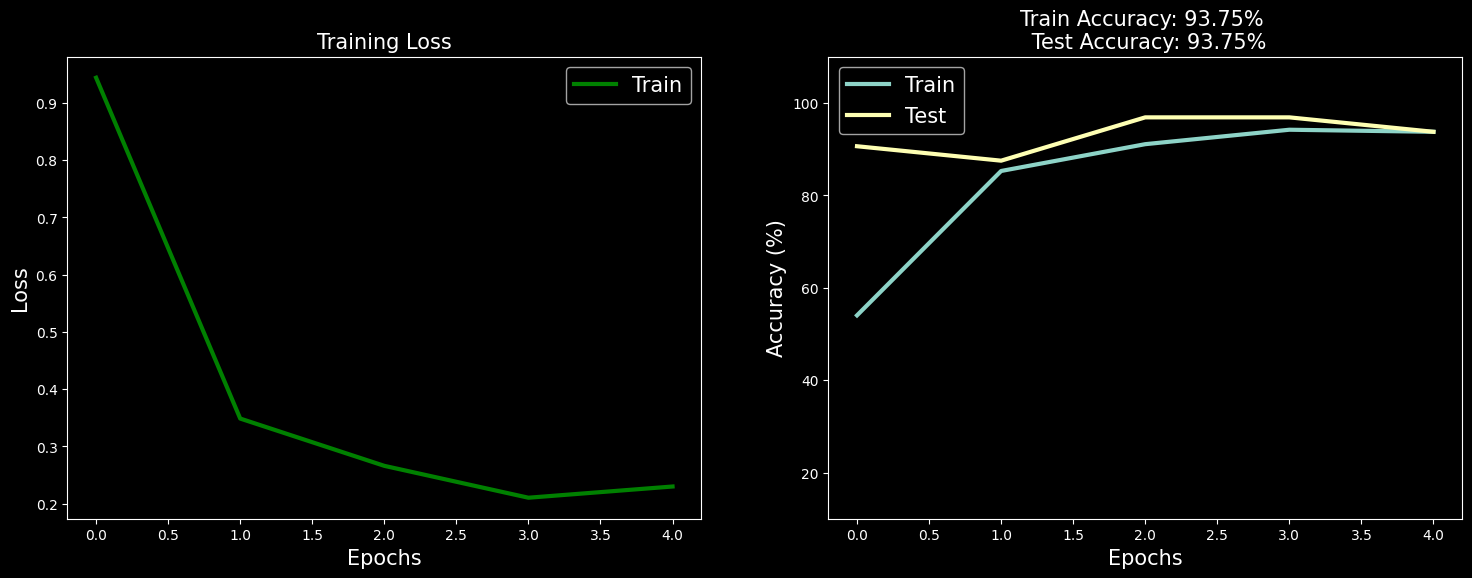

In [37]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()